In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import GWFrames
import scri.SpEC
from scri.SpEC import read_metadata_into_object
from scri import total_mass_from_chirp_mass_and_mass_ratio
from scri import m_sun_in_seconds as m_sun

data_dir = '/Users/boyle/Research/Data/SimulationAnnex/CatalogLinks/SXS:BBH:0317/Lev3/'

/Users/boyle/.continuum/anaconda/envs/gwframes/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


We can read in the metadata and establish some quantities.  These may not be the same as the optimal parameters, but they need to be consistent between NR and PN.

In [2]:
metadata = read_metadata_into_object(data_dir + '/metadata.txt')

m1 = metadata.relaxed_mass1
m2 = metadata.relaxed_mass2
chi1 = np.array(metadata.relaxed_spin1) / m1**2
chi2 = np.array(metadata.relaxed_spin2) / m2**2

# I guess(...) that the units on the metadata quantity are just those of M*Omega, so I'll divide by M to get units of M=1
Omega_orb_i = np.linalg.norm(metadata.relaxed_orbital_frequency) / (m1+m2)

Now, the mass ratio is fixed by the simulation, and the chirp mass is the most accurately determined quantity — not the total mass.  So we deduce the best total mass given this mass ratio and the observed chirp mass of $8.9^{+0.3}_{-0.3}\, M_\odot$:

In [3]:
m_tot = total_mass_from_chirp_mass_and_mass_ratio(8.9, m1/m2)
m_tot

25.094896328144973

We need about 16.65 seconds of data, after we scale the system to $25.1\, M_{\odot}$.  In terms of $M$ as we know it, that's about...

In [7]:
16.65 / (m_tot * m_sun)

134703.63227558156

Now read the NR waveform and offset so that the "relaxed" measurement time is $0$.

In [8]:
nr = GWFrames.ReadFromNRAR(data_dir + 'rhOverM_Asymptotic_GeometricUnits_CoM.h5/Extrapolated_N4.dir')
nr.SetT(nr.T()-metadata.relaxed_measurement_time);

In [9]:
approximant = 'TaylorT4'  # 'TaylorT1'|'TaylorT4'|'TaylorT5'
delta = (m1 - m2) / (m1 + m2)  # Normalized BH mass difference (M1-M2)/(M1+M2)
chi1_i = chi1  # Initial dimensionless spin vector of BH1
chi2_i = chi2  # Initial dimensionless spin vector of BH2
Omega_orb_i = Omega_orb_i  # Initial orbital angular frequency
Omega_orb_0 = Omega_orb_i/3  # Earliest orbital angular frequency to compute (default: Omega_orb_i)
# R_frame_i: Initial rotation of the binary (default: No rotation)
# MinStepsPerOrbit =   # Minimum number of time steps at which to evaluate (default: 32)
# PNWaveformModeOrder: PN order at which to compute waveform modes (default: 3.5)
# PNOrbitalEvolutionOrder: PN order at which to compute orbital evolution (default: 4.0)

pn = GWFrames.PNWaveform(approximant, delta, chi1_i, chi2_i, Omega_orb_i, Omega_orb_0)

<IPython.core.display.Javascript object>


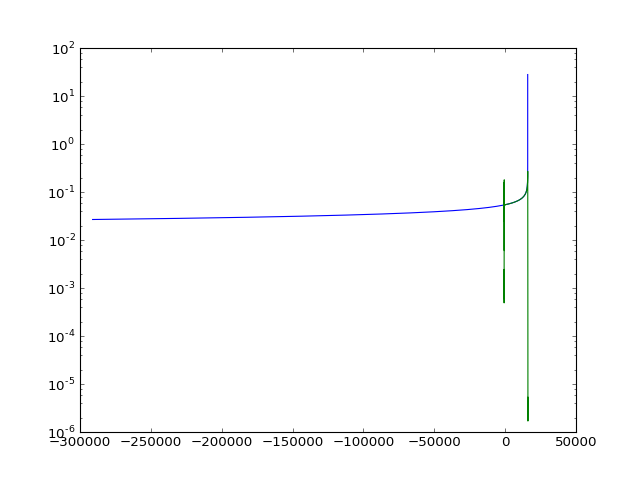

In [10]:
plt.close()
plt.semilogy(pn.T(), np.abs(pn.Data(0)))
plt.semilogy(nr.T(), np.abs(nr.Data(0)))

In [8]:
! /Users/boyle/.continuum/anaconda/envs/gwframes/bin/python ~/Research/Code/misc/GWFrames/Code/Scripts/HybridizeOneWaveform.py {data_dir} \
  --Waveform=rhOverM_Asymptotic_GeometricUnits_CoM.h5/Extrapolated_N4.dir --t1={metadata.relaxed_measurement_time} --t2=10000.0 \
  --InitialOmega_orb={Omega_orb_0} --Approximant=TaylorT4 --DirectAlignmentEvaluations=400

/Users/boyle/.continuum/anaconda/envs/gwframes/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Reading and transforming NR data
Reading and analyzing Horizons.h5 data
Constructing PN data:
GWFrames.PNWaveform(Approximant=TaylorT4, delta=0.533859044608,
    chia_0=[  2.65062908e-07  -1.79094844e-07   5.22629042e-01], chib_0=[  1.32195131e-07   2.51400444e-07  -4.48249974e-01],
    Omega_orb_0=0.0116020204236, InitialOmega_orb=0.00386606020543,
    R_frame_i=[0.851443480891835, 2.42618015470374e-07, 2.37365783471443e-07, 0.524446373661484],
    MinStepsPerOrbit=32, PNWaveformModeOrder=3.5, PNOrbitalEvolutionOrder=4.0)
PostNewtonian/C++/PNEvolution_Q.cpp:311:EvolvePN_Q: Velocity v has become greater than 1.0.  This is a nice way for PN to stop.
Aligning PN and NR waveforms
Waveforms.cpp:2655:Al

In [4]:
hybrid = scri.SpEC.read_from_h5(data_dir + 'rhOverM_Inertial_Hybrid.h5')
hybrid = hybrid[:-1]

In [5]:
h = hybrid.SI_units(current_unit_mass_in_solar_masses=m_tot, distance_from_source_in_megaparsecs=440)

t_merger = 16.65
h.max_norm_time()
h.t = h.t - h.max_norm_time() + t_merger

<IPython.core.display.Javascript object>


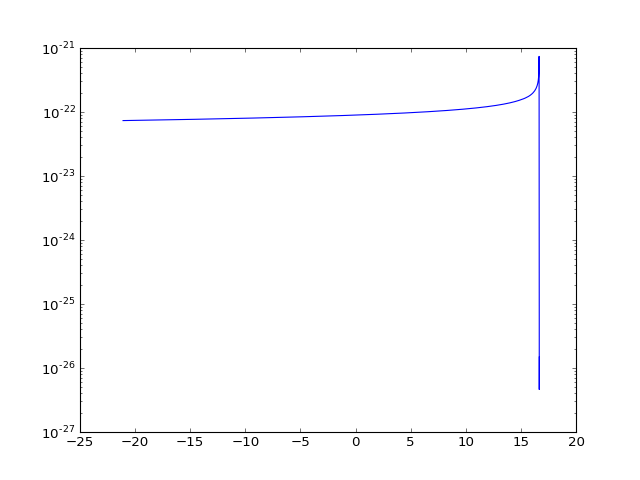

In [8]:
plt.close()
plt.semilogy(h.t, np.abs(h.data[:, 0]))

<IPython.core.display.Javascript object>


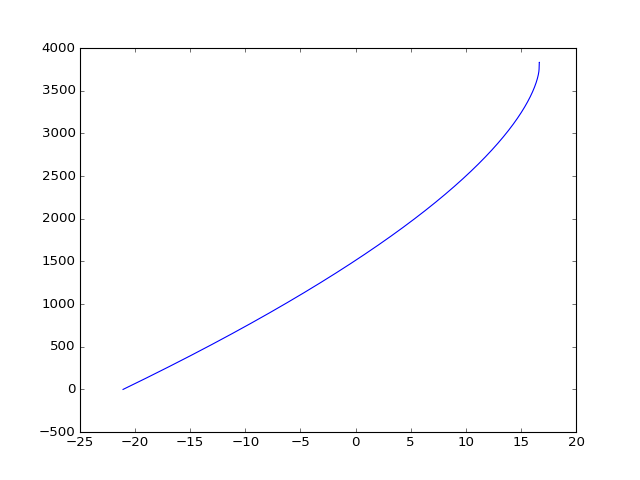

In [9]:
plt.close()
plt.plot(h.t, np.unwrap(np.angle(h.data[:, 0])))

In [10]:
import quaternion

<IPython.core.display.Javascript object>


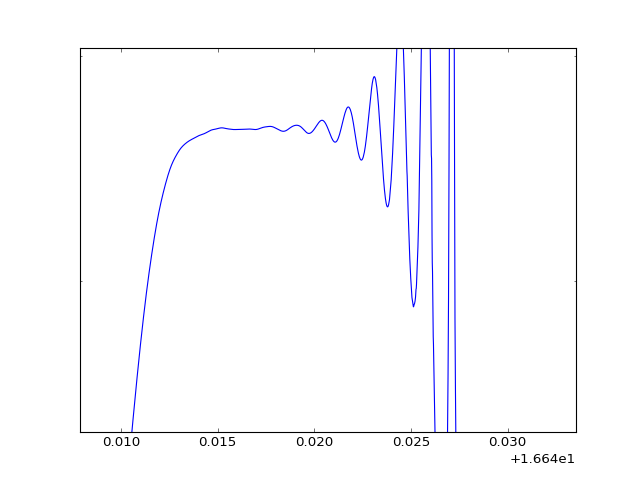

In [12]:
plt.close()
plt.semilogy(h.t, np.abs(quaternion.derivative(np.unwrap(np.angle(h.data[:, 0])), h.t)))

In [16]:
sampling_rate = 4*4096.  # Hz
dt = 1 / sampling_rate  # sec
t = np.linspace(0, 32, num=int(32*sampling_rate))
h_discrete = h.interpolate(t)
#h_discrete.data[np.argmax(t>16.4739):, :] = 1e-40j

In [14]:
from utilities import transition_function

In [17]:
h_trimmed = h_discrete.copy()
h_trimmed.data = (1-transition_function(h_discrete.t, 16.6525, 16.66))[:, np.newaxis] * h_discrete.data

<IPython.core.display.Javascript object>


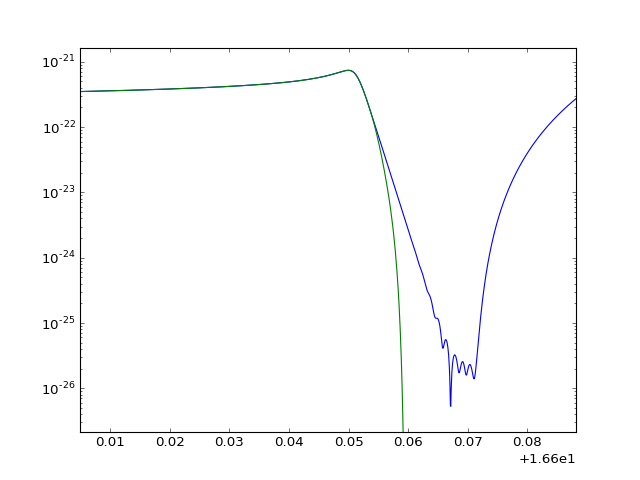

In [18]:
plt.close()
plt.semilogy(h_discrete.t, np.abs(h_discrete.data[:, 0]))
plt.semilogy(h_trimmed.t, np.abs(h_trimmed.data[:, 0]))

In [19]:
import quaternion
import spherical_functions as sf

In [20]:
sYlm = sf.SWSH(quaternion.one, h_discrete.spin_weight, h_discrete.LM)

(sYlm * h_trimmed.data).shape

(524288, 77)

In [21]:
h_data = np.tensordot(sYlm, h_trimmed.data, axes=([0, 1]))

In [22]:
np.savetxt('../Data/NR_GW151226.txt', np.vstack((h_data.real, h_data.imag)).T)

In [23]:
! head -n 1 ../Data/NR_GW151226.txt

-5.539540490417574246e-23 1.244919589654631313e-23
